# Shape Comparison Analysis

This notebook generates a 2×N grid comparing performance across different peg shapes:
- Top row: Success Rate vs Position Noise
- Bottom row: Break Rate vs Position Noise
- Each column shows the shape name and a cross-sectional icon
- Gold highlight box around the reference shape

In [ ]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import RegularPolygon, Rectangle, Circle, Ellipse, FancyBboxPatch
from collections import defaultdict

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Shape Levels - keys are internal names, each contains method tags
SHAPE_LEVELS = {
    "circle": {
        "Pose(1mm)": "pose_perf-comp:2026-01-05_10:54",
        "Hybrid-Basic(1mm)": "basic-hybrid_perf-comp:2026-01-05_10:54",
        "MATCH(1mm)": "LCLoP_fix_perf-comp:2026-01-09_11:17",
    },
    #"square": {
    #    "Pose": "PLACEHOLDER_POSE_SQUARE",
    #    "Hybrid-Basic": "PLACEHOLDER_HYBRID_SQUARE",
    #    "LCLoP": "PLACEHOLDER_LCLOP_SQUARE",
    #},
    "rectangle": {
        "Pose(1mm)": "pose_task_frag:2026-01-06_00:52",
        #"Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:56",
        #"MATCH(1mm)": "LCLoP_task_frag:2026-01-06_00:27",
    },
    "hexagon": {
        "Pose(1mm)": "pose_hex_degMap:2026-01-16_14:33",
    #    "Hybrid-Basic": "PLACEHOLDER_HYBRID_HEXAGON",
        "MATCH(1mm)": "LCLoP_hex_Fstd-05:2026-01-20_10:51",
    },
    "arch": {
        "Pose(1mm)": "pose_task_frag:2026-01-06_00:52",
        #"Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:56",
        #"MATCH(1mm)": "LCLoP_task_frag:2026-01-06_00:27",
    },
    #"arch": {
    #    "Pose(1mm)": "PLACEHOLDER_POSE_ARCH",
    #    "Hybrid-Basic(1mm)": "PLACEHOLDER_HYBRID_ARCH",
    #    "MATCH(1mm)": "PLACEHOLDER_MATCH_ARCH",
    #},
}

# Display name mapping
SHAPE_DISPLAY_NAMES = {
    "circle": "Circle",
    "square": "Square",
    "rectangle": "Rectangle",
    "hexagon": "Hexagon",
    "oval": "Oval",
    "arch": "Arch",
}

# Shape drawing configuration - maps shape key to drawing function parameters
# Each entry: (shape_type, kwargs for the patch)
# shape_type can be: 'circle', 'square', 'rectangle', 'hexagon', 'oval', 'polygon', 'arch'
SHAPE_ICONS = {
    "circle": ("circle", {}),
    "square": ("square", {}),
    "rectangle": ("rectangle", {"aspect": 0.5}),  # width/height ratio
    "hexagon": ("polygon", {"num_sides": 6}),
    "oval": ("oval", {"aspect": 0.6}),  # width/height ratio
    "arch": ("arch", {}),  # Roman/doorway arch
}

# Highlight box - which shape to highlight with gold box
HIGHLIGHT_SHAPE = "circle"  # Set to None for no highlight

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"
TAG_EVAL_NOISE = "eval_noise"

# Noise Level Mapping: display label -> metric range string
NOISE_LEVELS = {
    "1mm": "0mm-1mm",
    "2.5mm": "1mm-2.5mm",
    "5mm": "2.5mm-5mm",
    "7.5mm": "5mm-7.5mm",
}

# Metrics
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"
METRIC_TOTAL = "total_episodes"

In [2]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """Find the best checkpoint for each run with the given method tag."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    best_checkpoints = {}
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        best_checkpoints[run.id] = {
            "run_name": run.name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
        }
        print(f"    {run.name}: best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each shape and method
api = wandb.Api()
best_checkpoints = defaultdict(dict)  # best_checkpoints[shape][method]

for shape, method_tags in SHAPE_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Shape: {shape}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name} ({method_tag}):")
        best_checkpoints[shape][method_name] = get_best_checkpoint_per_run(api, method_tag)

wandb: Currently logged in as: robonuke (hur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Shape: circle

  Pose(1mm) (pose_perf-comp:2026-01-05_10:54):
    Eval_performance_pose_perf-comp_f(10)_0: best checkpoint at step 1228800 (score: 95)
    Eval_performance_pose_perf-comp_f(10)_1: best checkpoint at step 1536000 (score: 97)
    Eval_performance_pose_perf-comp_f(10)_3: best checkpoint at step 1920000 (score: 91)
    Eval_performance_pose_perf-comp_f(10)_4: best checkpoint at step 1113600 (score: 97)
    Eval_performance_pose_perf-comp_f(10)_2: best checkpoint at step 2496000 (score: 96)

  Hybrid-Basic(1mm) (basic-hybrid_perf-comp:2026-01-05_10:54):
    Eval_performance_basic-hybrid_perf-comp_f(10)_0: best checkpoint at step 1420800 (score: 94)
    Eval_performance_basic-hybrid_perf-comp_f(10)_1: best checkpoint at step 2803200 (score: 97)
    Eval_performance_basic-hybrid_perf-comp_f(10)_2: best checkpoint at step 2227200 (score: 96)
    Eval_performance_basic-hybrid_perf-comp_f(10)_3: best checkpoint at step 2534400 (score: 94)
    Eval_performance_basic-hybrid_perf-c

In [3]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

def download_eval_noise_data(api, method_tag, best_checkpoints):
    """Download eval_noise data for best checkpoints across all noise levels."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_NOISE}]}
    )

    # Build lookup by agent number from best_checkpoints
    checkpoint_by_agent = {}
    for run_id, info in best_checkpoints.items():
        agent_num = info["run_name"].rsplit("_", 1)[-1]
        checkpoint_by_agent[agent_num] = info["best_step"]

    data = []
    for run in runs:
        # Extract agent number from run name
        agent_num = run.name.rsplit("_", 1)[-1]

        if agent_num not in checkpoint_by_agent:
            print(f"Warning: No matching performance run for agent {agent_num} ({run.name})")
            continue

        best_step = checkpoint_by_agent[agent_num]
        history = run.history()
        
        if best_step not in history["total_steps"].values:
            print(f"Warning: Checkpoint {best_step} not found in {run.name}")
            continue
        
        row = history[history["total_steps"] == best_step].iloc[0]
        
        for noise_label, noise_range in NOISE_LEVELS.items():
            prefix = f"Noise_Eval({noise_range})_Core"
            data.append({
                "run_id": run.id,
                "run_name": run.name,
                "checkpoint": best_step,
                "noise_level": noise_label,
                "success": row[f"{prefix}/{METRIC_SUCCESS}"],
                "breaks": row[f"{prefix}/{METRIC_BREAKS}"],
                "total": row[f"{prefix}/{METRIC_TOTAL}"],
            })
    
    return pd.DataFrame(data)

# Download all data
noise_data = defaultdict(dict)  # noise_data[shape][method]

for shape, method_tags in SHAPE_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Downloading data for Shape: {shape}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name}...")
        noise_data[shape][method_name] = download_eval_noise_data(
            api, method_tag, best_checkpoints[shape][method_name]
        )

# Print summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
for shape in SHAPE_LEVELS.keys():
    print(f"\n{shape}:")
    for method_name in SHAPE_LEVELS[shape].keys():
        df = noise_data[shape][method_name]
        if not df.empty:
            num_runs = df["run_name"].nunique()
            print(f"  {method_name}: {num_runs} runs")
        else:
            print(f"  {method_name}: No data")



  Pose(1mm)...

  Hybrid-Basic(1mm)...

  MATCH(1mm)...


  Pose(1mm)...

  Hybrid-Basic(1mm)...

  MATCH(1mm)...


  Pose(1mm)...

  MATCH(1mm)...


  Pose(1mm)...

  Hybrid-Basic(1mm)...

  MATCH(1mm)...

DATA SUMMARY

circle:
  Pose(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs
  MATCH(1mm): 5 runs

rectangle:
  Pose(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs
  MATCH(1mm): 5 runs

hexagon:
  Pose(1mm): 3 runs
  MATCH(1mm): 5 runs

arch:
  Pose(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs
  MATCH(1mm): 5 runs


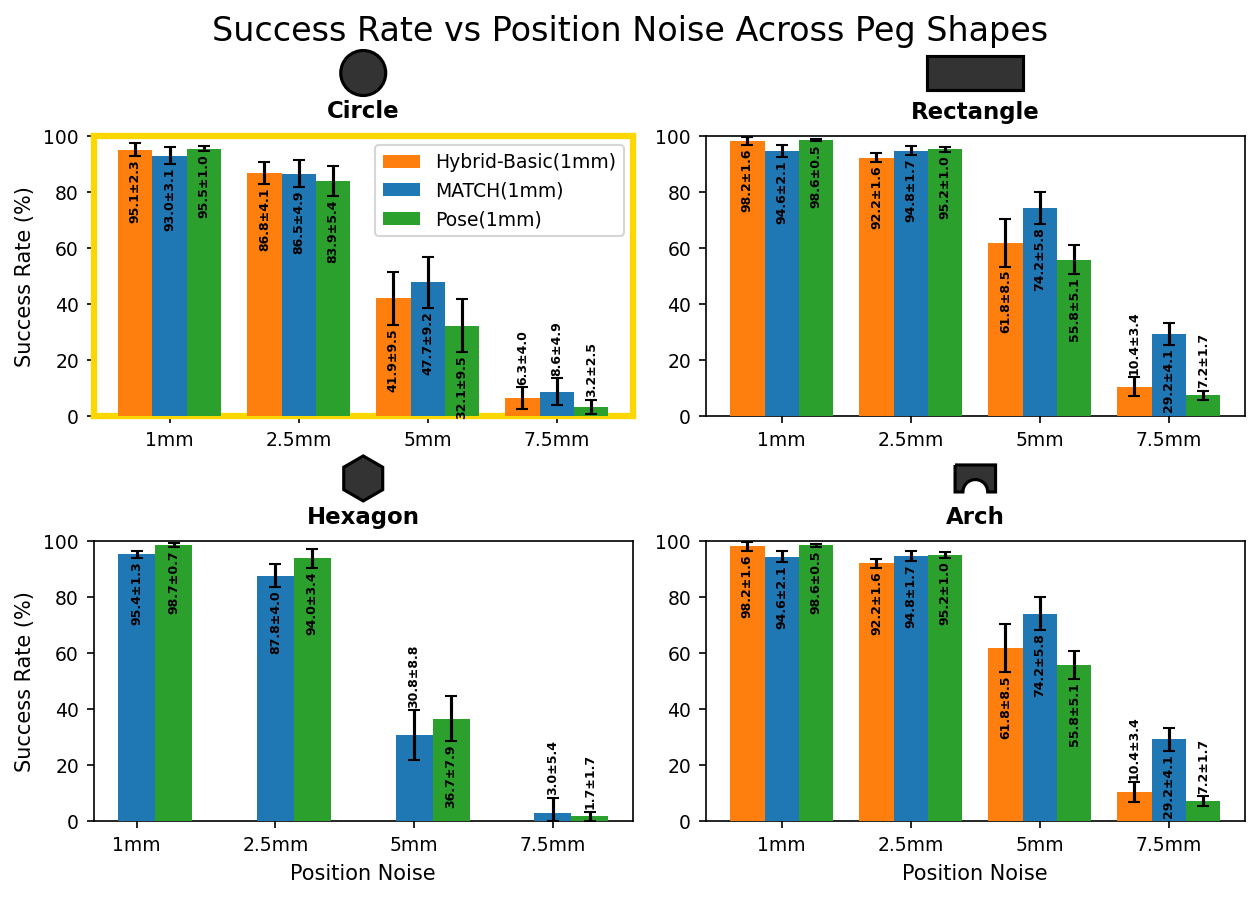

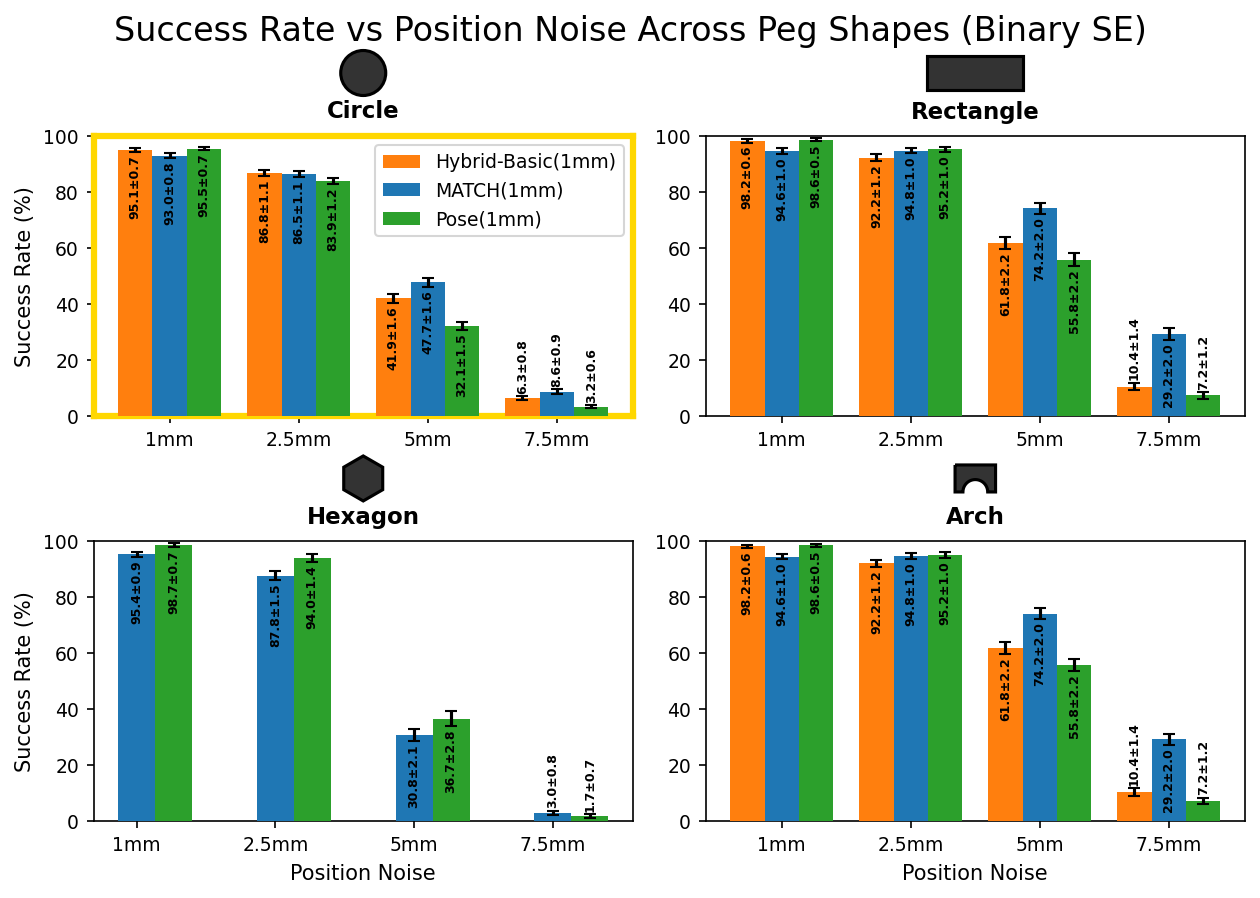

In [6]:
# ============================================================
# BLOCK 4: SUCCESS RATE COMPARISON FIGURE
# ============================================================

import math
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Highlight Configuration
HIGHLIGHT_SHAPE_PLOT = "circle"  # Which shape to highlight with gold box, or None
HIGHLIGHT_COLOR = "gold"
HIGHLIGHT_LINEWIDTH = 3

# Figure Configuration
FIGSIZE_PER_CELL = (4.25, 3)  # Width x Height per subplot cell
DPI = 150
ROW_SPACING = 0.15  # Extra vertical spacing between rows for shape icons

# Bar width is calculated dynamically based on number of methods
GROUP_WIDTH = 0.8

# Shape Icon Configuration
SHAPE_ICON_SIZE = 0.06  # Size of shape icon (in figure coordinates)
SHAPE_ICON_Y_OFFSET = 0.07  # Y offset above plot (increase to move icons higher)
SHAPE_TEXT_OFFSET = -0.03  # Text offset relative to icon (negative = below icon)
SHAPE_ICON_COLOR = "#333333"  # Dark gray fill
SHAPE_ICON_EDGE_COLOR = "black"
SHAPE_ICON_LINEWIDTH = 1.5

# Colors
COLORS = {
    "Pose": "#2ca02c",        # Green
    "Hybrid-Basic": "#ff7f0e", # Orange
    "MATCH": "#1f77b4",       # Blue
    "SWISH": "#1f77b4",       # Blue
    "LCLoP": "#1f77b4",       # Blue
}

# Font sizes
FONT_SUPTITLE = 16
FONT_TITLE = 11
FONT_AXIS_LABEL = 10
FONT_TICK = 9
FONT_LEGEND = 9
FONT_BAR_LABEL = 6  # Font size for bar value labels

# Axis configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]

# Labels
SUPTITLE = "Success Rate vs Position Noise Across Peg Shapes"
SUPTITLE_BINARY_SE = "Success Rate vs Position Noise Across Peg Shapes (Binary SE)"
X_LABEL = "Position Noise"
SUCCESS_Y_LABEL = "Success Rate (%)"

# ============================================================

def get_method_color(method_name):
    """Get color for a method, handling names like 'Pose(1mm)' by extracting base name."""
    if method_name in COLORS:
        return COLORS[method_name]
    # Extract base name (everything before parenthesis)
    base_name = method_name.split('(')[0]
    if base_name in COLORS:
        return COLORS[base_name]
    # Fallback to a default color
    return "#333333"

def draw_shape_icon(ax, shape_key, x, y, size, shape_icons_config):
    """Draw a shape icon at the specified position in axes coordinates."""
    if shape_key not in shape_icons_config:
        return
    
    shape_type, kwargs = shape_icons_config[shape_key]
    
    # Create inset axes for the shape
    if shape_type in ['oval', 'rectangle']:
        size = 1.5 * size
    inset_ax = ax.inset_axes([x - size/2, y - size/2, size, size], transform=ax.figure.transFigure)
    ax_size = 1.2
    inset_ax.set_xlim(-ax_size, ax_size)
    inset_ax.set_ylim(-ax_size, ax_size)
    inset_ax.axis('off')
    
    if shape_type == "circle":
        inset_ax.set_aspect('equal')
        patch = Circle((0, 0), 1, facecolor=SHAPE_ICON_COLOR, 
                       edgecolor=SHAPE_ICON_EDGE_COLOR, linewidth=SHAPE_ICON_LINEWIDTH)
    elif shape_type == "square":
        inset_ax.set_aspect('equal')
        patch = Rectangle((-0.9, -0.9), 1.8, 1.8, facecolor=SHAPE_ICON_COLOR,
                         edgecolor=SHAPE_ICON_EDGE_COLOR, linewidth=SHAPE_ICON_LINEWIDTH)
    elif shape_type == "rectangle":
        aspect = kwargs.get("aspect", 0.5)
        base_size = 2.0
        patch = Rectangle((-base_size/2.0, -base_size/2.0 * aspect), base_size, base_size * aspect, facecolor=SHAPE_ICON_COLOR,
                         edgecolor=SHAPE_ICON_EDGE_COLOR, linewidth=SHAPE_ICON_LINEWIDTH)
    elif shape_type == "oval":
        aspect = kwargs.get("aspect", 0.6)
        base_size = 2.0
        patch = Ellipse((0, 0), base_size, base_size * aspect, facecolor=SHAPE_ICON_COLOR,
                       edgecolor=SHAPE_ICON_EDGE_COLOR, linewidth=SHAPE_ICON_LINEWIDTH)
    elif shape_type == "polygon":
        inset_ax.set_aspect('equal')
        num_sides = kwargs.get("num_sides", 6)
        patch = RegularPolygon((0, 0), num_sides, radius=1, facecolor=SHAPE_ICON_COLOR,
                              edgecolor=SHAPE_ICON_EDGE_COLOR, linewidth=SHAPE_ICON_LINEWIDTH)
    elif shape_type == "arch":
        inset_ax.set_aspect('equal')
        # Rectangle with semicircular cutout from the bottom (like a bridge)
        rect_width = 1.8
        rect_height = 1.2
        arc_radius = 0.55  # radius of the semicircle cutout
        
        half_w = rect_width / 2
        half_h = rect_height / 2
        bottom_y = -half_h
        top_y = half_h
        
        n_arc_points = 30
        # Arc goes from right to left, curving upward into the rectangle
        theta = np.linspace(0, np.pi, n_arc_points)
        arc_x = arc_radius * np.cos(theta)
        arc_y = bottom_y + arc_radius * np.sin(theta)
        
        # Build path: top-left -> top-right -> bottom-right -> arc start -> 
        # arc (curving up) -> arc end -> bottom-left -> close
        verts = [(-half_w, top_y)]  # top-left
        verts.append((half_w, top_y))  # top-right
        verts.append((half_w, bottom_y))  # bottom-right
        verts.append((arc_radius, bottom_y))  # right side of arc
        # Add arc points (going from right to left, curving upward)
        for ax_pt, ay_pt in zip(arc_x, arc_y):
            verts.append((ax_pt, ay_pt))
        verts.append((-arc_radius, bottom_y))  # left side of arc
        verts.append((-half_w, bottom_y))  # bottom-left
        verts.append((-half_w, top_y))  # close to top-left
        
        codes = [Path.MOVETO] + [Path.LINETO] * (len(verts) - 1)
        path = Path(verts, codes)
        patch = PathPatch(path, facecolor=SHAPE_ICON_COLOR,
                         edgecolor=SHAPE_ICON_EDGE_COLOR, linewidth=SHAPE_ICON_LINEWIDTH)
    else:
        return
    
    inset_ax.add_patch(patch)
    return inset_ax

def filter_top_n_runs(df, method_best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if df.empty or top_n is None or len(method_best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(method_best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_names = {info["run_name"] for _, info in sorted_runs[:top_n]}
    top_agent_nums = {name.rsplit("_", 1)[-1] for name in top_run_names}
    return df[df["run_name"].apply(lambda x: x.rsplit("_", 1)[-1] in top_agent_nums)]

def compute_rates_with_ci(df, noise_labels, metric="success"):
    """Compute rates with 95% CI for each noise level. Returns means, cis, lower errors, upper errors."""
    if df.empty:
        zeros = [0] * len(noise_labels)
        return zeros, zeros, zeros, zeros
    
    means = []
    cis = []
    errors_lower = []
    errors_upper = []
    
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            subset = subset.copy()
            subset["rate"] = 100 * subset[metric] / subset["total"]
            mean = subset["rate"].mean()
            std = subset["rate"].std()
            n_seeds = len(subset)
            sem = std / np.sqrt(n_seeds)
            ci = 1.96 * sem
            errors_lower.append(min(ci, mean - 0))
            errors_upper.append(min(ci, 100 - mean))
            means.append(mean)
            cis.append(ci)
        else:
            means.append(0)
            cis.append(0)
            errors_lower.append(0)
            errors_upper.append(0)
    
    return means, cis, errors_lower, errors_upper

def compute_rates_with_binary_se(df, noise_labels, metric="success"):
    """Compute rates with binary SE for each noise level. Returns means, ses, lower errors, upper errors."""
    if df.empty:
        zeros = [0] * len(noise_labels)
        return zeros, zeros, zeros, zeros
    
    means = []
    binary_ses = []
    
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            total_successes = subset[metric].sum()
            total_episodes = subset["total"].sum()
            p = total_successes / total_episodes
            mean_pct = p * 100
            se = np.sqrt(p * (1 - p) / total_episodes) * 100
            means.append(mean_pct)
            binary_ses.append(se)
        else:
            means.append(0)
            binary_ses.append(0)
    
    errors_lower = [min(se, mean) for mean, se in zip(means, binary_ses)]
    errors_upper = [min(se, 100 - mean) for mean, se in zip(means, binary_ses)]
    
    return means, binary_ses, errors_lower, errors_upper

# Setup
shape_keys = list(SHAPE_LEVELS.keys())
# Get all unique method names across all shapes
all_method_names = set()
for shape in shape_keys:
    all_method_names.update(SHAPE_LEVELS[shape].keys())
method_names = list(all_method_names) #sorted(list(all_method_names))

noise_labels = list(NOISE_LEVELS.keys())
n_shapes = len(shape_keys)
x = np.arange(len(noise_labels))

# Calculate grid layout: 2 columns, as many rows as needed
n_cols = 2
n_rows = math.ceil(n_shapes / n_cols)

# Calculate bar width dynamically
n_methods = len(method_names)
BAR_WIDTH = GROUP_WIDTH / n_methods

# Calculate figure size based on grid
figsize = (FIGSIZE_PER_CELL[0] * n_cols, FIGSIZE_PER_CELL[1] * n_rows)

# ============================================================
# PLOT 1: Success Rate with 95% CI
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=DPI)
axes = np.atleast_2d(axes)  # Ensure 2D array even for single row
fig.suptitle(SUPTITLE, fontsize=FONT_SUPTITLE, y=0.99)

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    
    for i, method_name in enumerate(method_names):
        if method_name not in noise_data[shape]:
            continue
        df = noise_data[shape][method_name]
        df = filter_top_n_runs(df, best_checkpoints[shape][method_name], TOP_N_POLICIES)
        
        means, cis, err_lo, err_hi = compute_rates_with_ci(df, noise_labels, "success")
        offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
        
        bars = ax.bar(x + offset, means, BAR_WIDTH, 
                      label=method_name, color=get_method_color(method_name),
                      yerr=[err_lo, err_hi], capsize=3, zorder=3)
        
        # Add rotated mean±CI labels - inside bar if fits, above otherwise
        y_range = SUCCESS_Y_LIM[1] - SUCCESS_Y_LIM[0]
        label_height_estimate = y_range * 0.20

        for bar, mean, ci, err_lower, err_upper in zip(bars, means, cis, err_lo, err_hi):
            if mean > 0:
                space_inside = bar.get_height() - err_lower
                if space_inside > label_height_estimate + 2:
                    label_y = bar.get_height() - err_lower - 1
                    va = 'top'
                else:
                    label_y = bar.get_height() + err_upper + 1
                    va = 'bottom'

                ax.text(bar.get_x() + bar.get_width()/2, label_y,
                       f'{mean:.1f}±{ci:.1f}', ha='center', va=va,
                       rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')
    
    # Only show x-axis label on bottom row
    if row == n_rows - 1:
        ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
    ax.set_xticks(x)
    ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
    ax.set_ylim(SUCCESS_Y_LIM)
    ax.set_yticks(SUCCESS_Y_TICKS)
    ax.tick_params(axis='y', labelsize=FONT_TICK)
    
    if col == 0:
        ax.set_ylabel(SUCCESS_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    if idx == 0:
        ax.legend(fontsize=FONT_LEGEND, loc='upper right')
    
    if HIGHLIGHT_SHAPE_PLOT is not None and shape == HIGHLIGHT_SHAPE_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide empty subplots if odd number of shapes
for idx in range(n_shapes, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=ROW_SPACING + 0.3)  # Add extra space between rows for icons
fig.canvas.draw()

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    bbox = ax.get_position()
    center_x = bbox.x0 + bbox.width / 2
    icon_y = bbox.y1 + SHAPE_ICON_Y_OFFSET
    draw_shape_icon(ax, shape, center_x, icon_y, SHAPE_ICON_SIZE, SHAPE_ICONS)
    text_y = icon_y + SHAPE_TEXT_OFFSET  # Text position relative to icon
    fig.text(center_x, text_y, display_name, ha='center', va='top', 
             fontsize=FONT_TITLE, fontweight='bold')

plt.show()

# ============================================================
# PLOT 2: Success Rate with Binary SE
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=DPI)
axes = np.atleast_2d(axes)
fig.suptitle(SUPTITLE_BINARY_SE, fontsize=FONT_SUPTITLE, y=0.99)

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    
    for i, method_name in enumerate(method_names):
        if method_name not in noise_data[shape]:
            continue
        df = noise_data[shape][method_name]
        df = filter_top_n_runs(df, best_checkpoints[shape][method_name], TOP_N_POLICIES)
        
        means, ses, err_lo, err_hi = compute_rates_with_binary_se(df, noise_labels, "success")
        offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
        
        bars = ax.bar(x + offset, means, BAR_WIDTH, 
                      label=method_name, color=get_method_color(method_name),
                      yerr=[err_lo, err_hi], capsize=3, zorder=3)
        
        y_range = SUCCESS_Y_LIM[1] - SUCCESS_Y_LIM[0]
        label_height_estimate = y_range * 0.20

        for bar, mean, se, err_lower, err_upper in zip(bars, means, ses, err_lo, err_hi):
            if mean > 0:
                space_inside = bar.get_height() - err_lower
                if space_inside > label_height_estimate + 2:
                    label_y = bar.get_height() - err_lower - 1
                    va = 'top'
                else:
                    label_y = bar.get_height() + err_upper + 1
                    va = 'bottom'

                ax.text(bar.get_x() + bar.get_width()/2, label_y,
                       f'{mean:.1f}±{se:.1f}', ha='center', va=va,
                       rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')
    
    # Only show x-axis label on bottom row
    if row == n_rows - 1:
        ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
    ax.set_xticks(x)
    ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
    ax.set_ylim(SUCCESS_Y_LIM)
    ax.set_yticks(SUCCESS_Y_TICKS)
    ax.tick_params(axis='y', labelsize=FONT_TICK)
    
    if col == 0:
        ax.set_ylabel(SUCCESS_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    if idx == 0:
        ax.legend(fontsize=FONT_LEGEND, loc='upper right')
    
    if HIGHLIGHT_SHAPE_PLOT is not None and shape == HIGHLIGHT_SHAPE_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide empty subplots if odd number of shapes
for idx in range(n_shapes, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=ROW_SPACING + 0.3)  # Add extra space between rows for icons
fig.canvas.draw()

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    bbox = ax.get_position()
    center_x = bbox.x0 + bbox.width / 2
    icon_y = bbox.y1 + SHAPE_ICON_Y_OFFSET
    draw_shape_icon(ax, shape, center_x, icon_y, SHAPE_ICON_SIZE, SHAPE_ICONS)
    text_y = icon_y + SHAPE_TEXT_OFFSET  # Text position relative to icon
    fig.text(center_x, text_y, display_name, ha='center', va='top', 
             fontsize=FONT_TITLE, fontweight='bold')

plt.show()

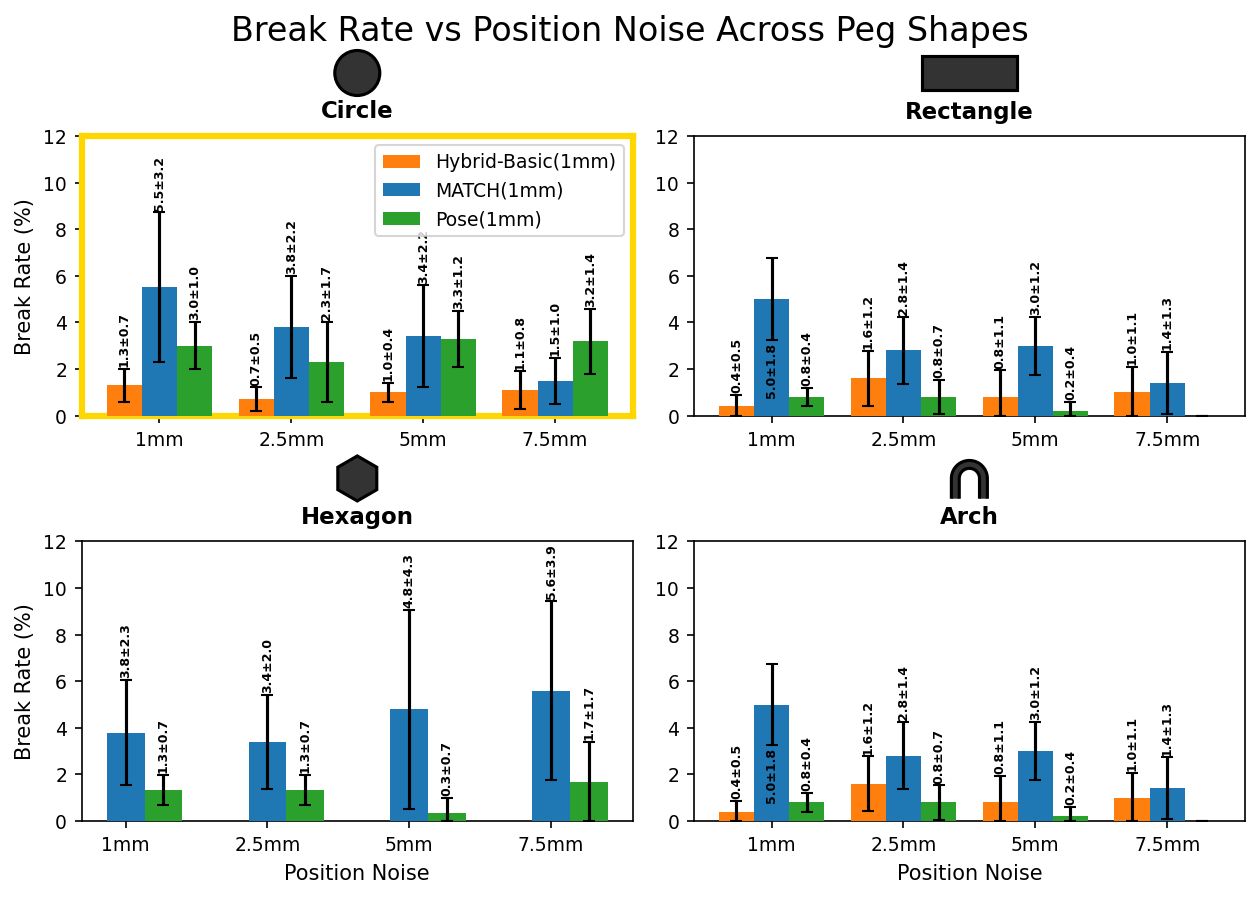

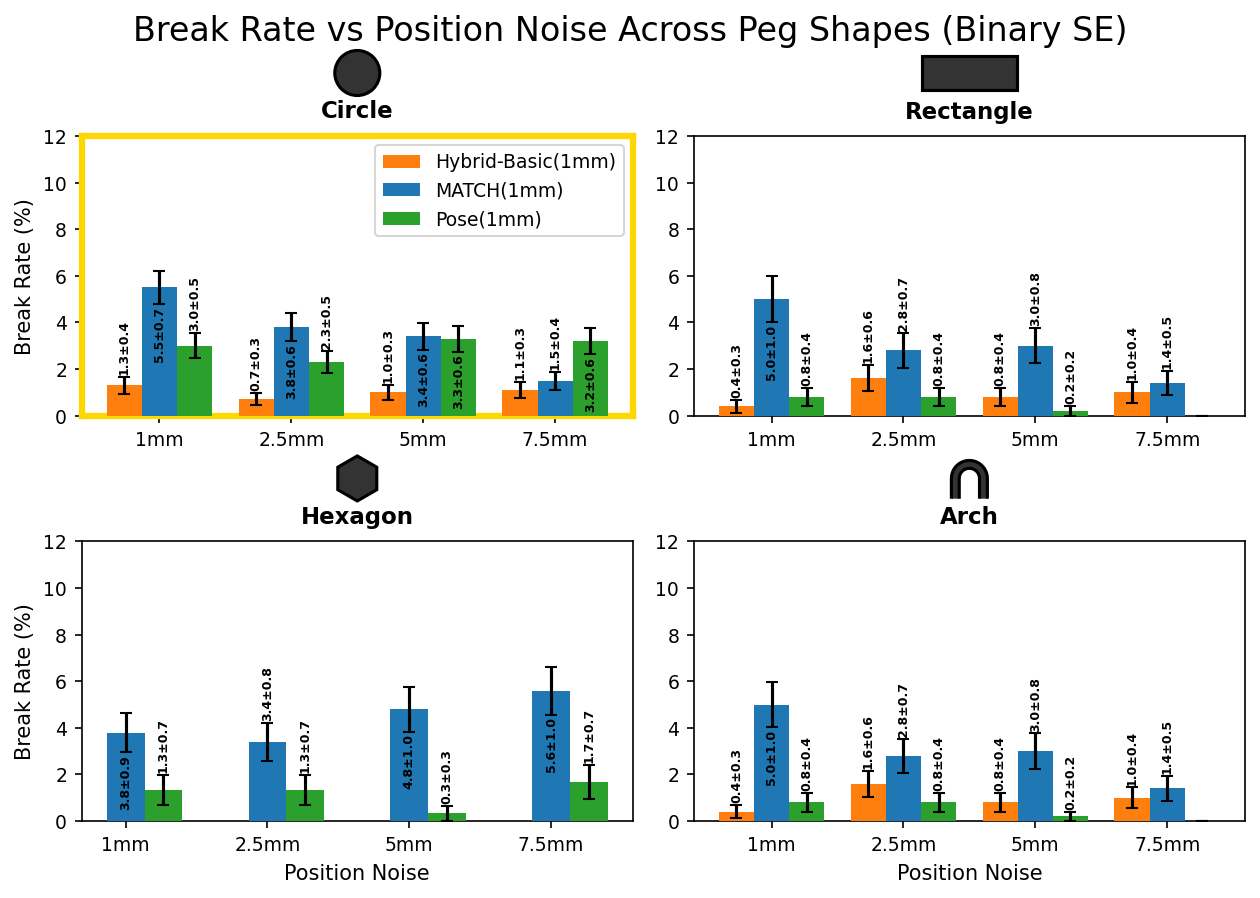

In [5]:
# ============================================================
# BLOCK 5: BREAK RATE COMPARISON FIGURE
# ============================================================

# N/A Configuration - for shapes where break rate is not applicable
NA_SHAPES = []  # List of shape keys to show N/A instead of break rate plot
NA_TEXT = "N/A"  # Text to display in the N/A box

# Axis configuration
BREAK_Y_LIM = (0, 12)
BREAK_Y_TICKS = [0, 2, 4, 6, 8, 10, 12]

# Labels
SUPTITLE_BREAK = "Break Rate vs Position Noise Across Peg Shapes"
SUPTITLE_BREAK_BINARY_SE = "Break Rate vs Position Noise Across Peg Shapes (Binary SE)"
BREAK_Y_LABEL = "Break Rate (%)"

# Font sizes
FONT_NA = 12  # Font size for N/A text

# ============================================================

# Setup (reuse from Block 4)
shape_keys = list(SHAPE_LEVELS.keys())
all_method_names = set()
for shape in shape_keys:
    all_method_names.update(SHAPE_LEVELS[shape].keys())
method_names = sorted(list(all_method_names))

noise_labels = list(NOISE_LEVELS.keys())
n_shapes = len(shape_keys)
x = np.arange(len(noise_labels))

# Calculate grid layout: 2 columns, as many rows as needed
n_cols = 2
n_rows = math.ceil(n_shapes / n_cols)

n_methods = len(method_names)
BAR_WIDTH = GROUP_WIDTH / n_methods

# Calculate figure size based on grid
figsize = (FIGSIZE_PER_CELL[0] * n_cols, FIGSIZE_PER_CELL[1] * n_rows)

# ============================================================
# PLOT 1: Break Rate with 95% CI
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=DPI)
axes = np.atleast_2d(axes)
fig.suptitle(SUPTITLE_BREAK, fontsize=FONT_SUPTITLE, y=0.99)

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    is_na_shape = shape in NA_SHAPES
    
    if is_na_shape:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.5, 0.5, NA_TEXT, transform=ax.transAxes,
                fontsize=FONT_NA, ha='center', va='center',
                style='italic', color='gray')
        for spine in ax.spines.values():
            spine.set_visible(True)
    else:
        for i, method_name in enumerate(method_names):
            if method_name not in noise_data[shape]:
                continue
            df = noise_data[shape][method_name]
            df = filter_top_n_runs(df, best_checkpoints[shape][method_name], TOP_N_POLICIES)
            
            means, cis, err_lo, err_hi = compute_rates_with_ci(df, noise_labels, "breaks")
            offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
            
            bars = ax.bar(x + offset, means, BAR_WIDTH, 
                          label=method_name, color=get_method_color(method_name),
                          yerr=[err_lo, err_hi], capsize=3, zorder=3)
            
            y_range = BREAK_Y_LIM[1] - BREAK_Y_LIM[0]
            label_height_estimate = y_range * 0.20

            for bar, mean, ci, err_lower, err_upper in zip(bars, means, cis, err_lo, err_hi):
                if mean > 0:
                    space_inside = bar.get_height() - err_lower
                    if space_inside > label_height_estimate + 0.2:
                        label_y = bar.get_height() - err_lower - 0.1
                        va = 'top'
                    else:
                        label_y = bar.get_height() + err_upper + 0.1
                        va = 'bottom'

                    ax.text(bar.get_x() + bar.get_width()/2, label_y,
                           f'{mean:.1f}±{ci:.1f}', ha='center', va=va,
                           rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')
        
        # Only show x-axis label on bottom row
        if row == n_rows - 1:
            ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
        ax.set_xticks(x)
        ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
        ax.set_ylim(BREAK_Y_LIM)
        ax.set_yticks(BREAK_Y_TICKS)
        ax.tick_params(axis='y', labelsize=FONT_TICK)
    
    if col == 0:
        ax.set_ylabel(BREAK_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    if idx == 0 and not is_na_shape:
        ax.legend(fontsize=FONT_LEGEND, loc='upper right')
    
    if HIGHLIGHT_SHAPE_PLOT is not None and shape == HIGHLIGHT_SHAPE_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide empty subplots if odd number of shapes
for idx in range(n_shapes, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=ROW_SPACING + 0.3)  # Add extra space between rows for icons
fig.canvas.draw()

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    bbox = ax.get_position()
    center_x = bbox.x0 + bbox.width / 2
    icon_y = bbox.y1 + SHAPE_ICON_Y_OFFSET
    draw_shape_icon(ax, shape, center_x, icon_y, SHAPE_ICON_SIZE, SHAPE_ICONS)
    text_y = icon_y + SHAPE_TEXT_OFFSET  # Text position relative to icon
    fig.text(center_x, text_y, display_name, ha='center', va='top', 
             fontsize=FONT_TITLE, fontweight='bold')

plt.show()

# ============================================================
# PLOT 2: Break Rate with Binary SE
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=DPI)
axes = np.atleast_2d(axes)
fig.suptitle(SUPTITLE_BREAK_BINARY_SE, fontsize=FONT_SUPTITLE, y=0.99)

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    is_na_shape = shape in NA_SHAPES
    
    if is_na_shape:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.5, 0.5, NA_TEXT, transform=ax.transAxes,
                fontsize=FONT_NA, ha='center', va='center',
                style='italic', color='gray')
        for spine in ax.spines.values():
            spine.set_visible(True)
    else:
        for i, method_name in enumerate(method_names):
            if method_name not in noise_data[shape]:
                continue
            df = noise_data[shape][method_name]
            df = filter_top_n_runs(df, best_checkpoints[shape][method_name], TOP_N_POLICIES)
            
            means, ses, err_lo, err_hi = compute_rates_with_binary_se(df, noise_labels, "breaks")
            offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
            
            bars = ax.bar(x + offset, means, BAR_WIDTH, 
                          label=method_name, color=get_method_color(method_name),
                          yerr=[err_lo, err_hi], capsize=3, zorder=3)
            
            y_range = BREAK_Y_LIM[1] - BREAK_Y_LIM[0]
            label_height_estimate = y_range * 0.20

            for bar, mean, se, err_lower, err_upper in zip(bars, means, ses, err_lo, err_hi):
                if mean > 0:
                    space_inside = bar.get_height() - err_lower
                    if space_inside > label_height_estimate + 0.2:
                        label_y = bar.get_height() - err_lower - 0.1
                        va = 'top'
                    else:
                        label_y = bar.get_height() + err_upper + 0.1
                        va = 'bottom'

                    ax.text(bar.get_x() + bar.get_width()/2, label_y,
                           f'{mean:.1f}±{se:.1f}', ha='center', va=va,
                           rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')
        
        # Only show x-axis label on bottom row
        if row == n_rows - 1:
            ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
        ax.set_xticks(x)
        ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
        ax.set_ylim(BREAK_Y_LIM)
        ax.set_yticks(BREAK_Y_TICKS)
        ax.tick_params(axis='y', labelsize=FONT_TICK)
    
    if col == 0:
        ax.set_ylabel(BREAK_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    if idx == 0 and not is_na_shape:
        ax.legend(fontsize=FONT_LEGEND, loc='upper right')
    
    if HIGHLIGHT_SHAPE_PLOT is not None and shape == HIGHLIGHT_SHAPE_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide empty subplots if odd number of shapes
for idx in range(n_shapes, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=ROW_SPACING + 0.3)  # Add extra space between rows for icons
fig.canvas.draw()

for idx, shape in enumerate(shape_keys):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    display_name = SHAPE_DISPLAY_NAMES.get(shape, shape)
    bbox = ax.get_position()
    center_x = bbox.x0 + bbox.width / 2
    icon_y = bbox.y1 + SHAPE_ICON_Y_OFFSET
    draw_shape_icon(ax, shape, center_x, icon_y, SHAPE_ICON_SIZE, SHAPE_ICONS)
    text_y = icon_y + SHAPE_TEXT_OFFSET  # Text position relative to icon
    fig.text(center_x, text_y, display_name, ha='center', va='top', 
             fontsize=FONT_TITLE, fontweight='bold')

plt.show()